In [28]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [2]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rhjha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rhjha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rhjha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Importing the dataset
with open('kampus_merdeka_cmplt.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [3]:
# Cetak data keseluruhan
data 

,patterns,tags
0,hai,greeting
1,punten,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
600,Berapa lama program KKNT berlangsung?,jangka_waktu_kknt
601,Berapa periode waktu yang diperlukan dalam pro...,jangka_waktu_kknt
602,Berapa lamakah program KKNT berjalan?,jangka_waktu_kknt
603,Berapa estimasi waktu yang dibutuhkan untuk me...,jangka_waktu_kknt


In [4]:
# Cetak data baris pertama sampai baris kelima
data.head() 

,patterns,tags
0,hai,greeting
1,punten,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


In [5]:
# Cetak data baris ke-70 sampai baris akhir
data.tail() 

,patterns,tags
600,Berapa lama program KKNT berlangsung?,jangka_waktu_kknt
601,Berapa periode waktu yang diperlukan dalam pro...,jangka_waktu_kknt
602,Berapa lamakah program KKNT berjalan?,jangka_waktu_kknt
603,Berapa estimasi waktu yang dibutuhkan untuk me...,jangka_waktu_kknt
604,Berapa waktu yang dibutuhkan untuk menyelesaik...,jangka_waktu_kknt


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  605 non-null    object
 1   tags      605 non-null    object
dtypes: object(2)
memory usage: 9.6+ KB


In [7]:
data['patterns']

0                                                    hai
1                                                 punten
2                                                   halo
3                                                    hei
4                                                     hi
                             ...                        
600                Berapa lama program KKNT berlangsung?
601    Berapa periode waktu yang diperlukan dalam pro...
602                Berapa lamakah program KKNT berjalan?
603    Berapa estimasi waktu yang dibutuhkan untuk me...
604    Berapa waktu yang dibutuhkan untuk menyelesaik...
Name: patterns, Length: 605, dtype: object

In [8]:
len(data['patterns'])

605

# Preprocessing

In [9]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hai,greeting
1,punten,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
600,berapa lama program kknt berlangsung,jangka_waktu_kknt
601,berapa periode waktu yang diperlukan dalam pro...,jangka_waktu_kknt
602,berapa lamakah program kknt berjalan,jangka_waktu_kknt
603,berapa estimasi waktu yang dibutuhkan untuk me...,jangka_waktu_kknt


In [10]:
data['patterns']

0                                                    hai
1                                                 punten
2                                                   halo
3                                                    hei
4                                                     hi
                             ...                        
600                 berapa lama program kknt berlangsung
601    berapa periode waktu yang diperlukan dalam pro...
602                 berapa lamakah program kknt berjalan
603    berapa estimasi waktu yang dibutuhkan untuk me...
604    berapa waktu yang dibutuhkan untuk menyelesaik...
Name: patterns, Length: 605, dtype: object

In [11]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

285 unique lemmatized words ['ada', 'adalah', 'again', 'ajukan', 'akan', 'akhir', 'alternatif', 'apa', 'apabila', 'apakah', 'asal', 'atau', 'bagaimana', 'bagi', 'bagian', 'bangkit', 'bantuannya', 'banyak', 'bayar', 'bayaran', 'bekerja', 'berapa', 'berbagai', 'berhak', 'berjalan', 'berkolaborasi', 'berlangsung', 'bersertifikat', 'bervariasi', 'biaya', 'bidang', 'bidang/jurusan', 'bisa', 'boleh', 'bye', 'byee', 'cara', 'coba', 'dadah', 'daerah', 'daftar', 'daftarkan', 'dah', 'dalam', 'dan', 'dapat', 'dapatkah', 'dari', 'dasar', 'defenisi', 'dengan', 'di', 'diadakan', 'diadakannya', 'diambil', 'diatur', 'dibayar', 'diberikan', 'dibutuhkan', 'dicapai', 'didapatkan', 'diharuskan', 'diikuti', 'diizinkan', 'dilaksanakan', 'dilakukan', 'dimaksud', 'dimana', 'dimiliki', 'dipenuhi', 'diperbolehkan', 'diperlukan', 'diperoleh', 'dipersiapkan', 'dipilih', 'diri', 'diselenggarakan', 'ditawarkan', 'dunia', 'durasi', 'estimasi', 'gaji', 'good', 'hadir', 'hai', 'hal', 'hal-hal', 'halo', 'harus', 'hei',

In [12]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

60 classes ['ITTPBot', 'biaya_studi_independen', 'daftar_lowongan_magang', 'gaji_magang', 'goodbye', 'greeting', 'jangka_waktu_kknt', 'jenis_kampus_merdeka', 'jurusan_magang', 'jurusan_studi_independen', 'lokasi_kknt', 'lowongan_magang', 'manfaat_IISMA', 'manfaat_PMMB', 'manfaat_bangkit', 'manfaat_kampus_mengajar', 'manfaat_kknt', 'manfaat_magang', 'manfaat_pejuang_muda', 'manfaat_pertukaran_mahasiswa', 'manfaat_studi_independen', 'mitra_IISMA', 'mitra_PMMB', 'mitra_magang', 'mitra_studi_independen', 'pelaksanaan_studi_independen', 'penjelasan_IISMA', 'penjelasan_PMMB', 'penjelasan_bangkit', 'penjelasan_kampus_mengajar', 'penjelasan_kampus_merdeka', 'penjelasan_kknt', 'penjelasan_magang', 'penjelasan_pejuang_muda', 'penjelasan_pertukaran_mahasiswa', 'penjelasan_studi_independen', 'perguruan_tinggi_magang', 'perguruan_tinggi_studi_independen', 'periode_dan_pendaftaran_IISMA', 'periode_dan_pendaftaran_PMMB', 'periode_dan_pendaftaran_kampus_mengajar', 'periode_dan_pendaftaran_magang', 'pe

In [13]:
# documents = combination between patterns and intents
print (len(documents), "documents")

6107 documents


In [14]:
pickle.dump(words, open('model-complete/words.pkl','wb'))
pickle.dump(classes, open('model-complete/classes.pkl','wb'))

In [15]:
# import pandas as pd
# from matplotlib import pyplot as plt

# # Read CSV into pandas
# datalabel = {"Greeting":15, "ITTPBot":4, "Goodbye":8, "Terimakasih":5, "Penjelasan kampus merdeka":4, "Tujuan kampus merdeka":3, 
#         "Persyaratan kampus merdeka":4, "Jenis kampus merdeka":2, "Program kampus merdeka":5, "Penjelasan studi independen":4, 
#         "Persyaratan studi independen":3, "Perguruan tinggi studi independen":3, "Jurusan studi independen":4, 
#         "Biaya studi independen":3, "Pilihan studi studi independen":3, "Pelaksanaan studi independen":3, 
#         "Periode dan pendaftaran studi independen":6, "Manfaat studi independen":4, "Mitra studi independen":3, 
#         "Penjelasan magang":5, "Persyaratan magang":4, "Perguruan tinggi magang":3, "Jurusan magang":3, "Gaji magang":4, 
#         "Seleksi magang":3, "Periode dan pendaftaran magang":5,  "Manfaat magang":5, "Mitra magang":3, "Lowongan magang":5, 
#         "Daftar lowongan magang":3, "Penjelasan kampus mengajar":4, "Persyaratan kampus mengajar":4, 
#         "Periode dan pendaftaran kampus mengajar":5, "Manfaat kampus mengajar":4, "Penjelasan IISMA":4, "Persyaratan IISMA":4,  
#         "Periode dan pendaftaran IISMA":5, "Manfaat IISMA":4, "Mitra IISMA":4, "Penjelasan pertukaran mahasiswa":6, 
#         "Persyaratan pertukaran mahasiswa":4, "Manfaat pertukaran mahasiswa":4, "Penjelasan pejuang muda":4, 
#         "Persyaratan pejuang muda":4, "Periode dan pendaftaran pejuang muda":4, "Manfaat pejuang muda":4, "Penjelasan PMMB":4, 
#         "Persyaratan PMMB":4, "Periode dan pendaftaran PMMB":5, "Manfaat PMMB":4, "Mitra PMMB":3, "Penjelasan bangkit":4, 
#         "Persyaratan bangkit":3, "Program bangkit":3, "Manfaat bangkit":3, "Penjelasan KKNT":4, "Tujuan KKNT":3, "Manfaat KKNT":4, 
#         "Persyaratan KKNT":3, "Lokasi KKNT":4, "Jangka Waktu KKNT":4}

# name = list(datalabel.keys())
# price = list(datalabel.values())

# # Figure Size
# fig, ax = plt.subplots(figsize =(15, 15))

# # Horizontal Bar Plot
# ax.barh(name, price)

# # Remove axes splines
# for s in ['top', 'bottom', 'left', 'right']:
#     ax.spines[s].set_visible(False)

# # Remove x, y Ticks
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')

# # Add padding between axes and labels
# ax.xaxis.set_tick_params(pad = 5)
# ax.yaxis.set_tick_params(pad = 10)

# # Add x, y gridlines
# ax.grid(b = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5, alpha = 0.2)

# # Show top values
# ax.invert_yaxis()

# # Add annotation to bars
# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey')

# # Add Plot Title
# ax.set_title('Kelas pertanyaan', loc ='left', )

# # Add Text watermark
# fig.text(0.9, 0.15, 'Muhammad Rahaji Jhaerol', fontsize = 12,
#          color ='grey', ha ='right', va ='bottom', alpha = 0.7)

# # save plot
# plt.savefig('model-new/kelas_pertanyaan.png', dpi=300, bbox_inches='tight')

# # Show Plot
# plt.show()



In [16]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train_sequence = tokenizer.texts_to_sequences(data['patterns'])
train_sequence

[[175],
 [176],
 [177],
 [178],
 [179],
 [180],
 [181],
 [182],
 [183],
 [184],
 [2, 45, 69],
 [39, 69],
 [117, 39],
 [39, 117],
 [69, 45, 39],
 [69, 39],
 [69, 45, 2],
 [39, 45, 69],
 [40, 69],
 [56, 69],
 [185],
 [186],
 [134],
 [187],
 [188, 134],
 [189, 190],
 [135, 136],
 [137, 102],
 [135, 136, 191],
 [137, 102, 192],
 [193],
 [138, 102],
 [88, 89],
 [139],
 [88, 89, 58],
 [88, 89, 194, 195],
 [139, 58],
 [138, 102, 196, 197],
 [88, 89, 58, 198],
 [88, 89, 58, 199],
 [2, 45, 9, 12],
 [2, 9, 12],
 [9, 12],
 [9, 12, 59],
 [40, 9, 12],
 [43, 9, 12],
 [2, 43, 10, 9, 12],
 [2, 40, 10, 9, 12],
 [56, 9, 12],
 [2, 56, 10, 9, 12],
 [2, 47, 9, 12],
 [47, 9, 12, 59],
 [47, 10, 9, 12],
 [2, 47, 10, 9, 12],
 [47, 9, 12],
 [9, 12, 200, 47],
 [118, 47, 10, 9, 12],
 [201, 117, 202, 47, 10, 9, 12],
 [203, 118, 47, 9, 12],
 [9, 12, 140, 47],
 [2, 19, 4, 9, 12],
 [27, 9, 12],
 [27, 4, 9, 12],
 [2, 27, 9, 12],
 [2, 5, 27, 9, 12],
 [2, 27, 4, 9, 12],
 [19, 9, 12],
 [19, 4, 9, 12],
 [118, 204, 9, 12],

In [17]:
tokenizer.word_index

{'program': 1,
 'apa': 2,
 'yang': 3,
 'mengikuti': 4,
 'saja': 5,
 'magang': 6,
 'studi': 7,
 'independen': 8,
 'kampus': 9,
 'dari': 10,
 'mahasiswa': 11,
 'merdeka': 12,
 'manfaat': 13,
 'kknt': 14,
 'untuk': 15,
 'iisma': 16,
 'pmmb': 17,
 'apakah': 18,
 'persyaratan': 19,
 'harus': 20,
 'mengajar': 21,
 'pejuang': 22,
 'muda': 23,
 'bangkit': 24,
 'berapa': 25,
 'dapat': 26,
 'syarat': 27,
 'dalam': 28,
 'saya': 29,
 'di': 30,
 'dengan': 31,
 'pertukaran': 32,
 'dipenuhi': 33,
 'mendaftar': 34,
 'keuntungan': 35,
 'periode': 36,
 'bagaimana': 37,
 'cara': 38,
 'siapa': 39,
 'defenisi': 40,
 'bisa': 41,
 'mitra': 42,
 'pengertian': 43,
 'didapatkan': 44,
 'itu': 45,
 'mana': 46,
 'tujuan': 47,
 'bersertifikat': 48,
 'lama': 49,
 'lowongan': 50,
 'peserta': 51,
 'perlu': 52,
 'sebagai': 53,
 'jurusan': 54,
 'menjadi': 55,
 'penjelasan': 56,
 'ada': 57,
 'banyak': 58,
 'adalah': 59,
 'waktu': 60,
 'kriteria': 61,
 'jenjang': 62,
 'pelaksanaan': 63,
 'diperoleh': 64,
 'universitas': 6

In [18]:
train_sequence[:20]

[[175],
 [176],
 [177],
 [178],
 [179],
 [180],
 [181],
 [182],
 [183],
 [184],
 [2, 45, 69],
 [39, 69],
 [117, 39],
 [39, 117],
 [69, 45, 39],
 [69, 39],
 [69, 45, 2],
 [39, 45, 69],
 [40, 69],
 [56, 69]]

In [19]:
# Apply padding 
x_train = pad_sequences(train_sequence)
print(x_train[:20]) # Padding Sequences

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 175]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 176]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 177]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 178]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 179]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 180]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 181]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 182]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 183]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 184]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   2  45  69]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  39  69]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 117  39]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  39 117]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  69  45 

In [20]:
x_train.shape

(605, 16)

In [21]:
# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[ 5  5  5  5  5  5  5  5  5  5  0  0  0  0  0  0  0  0  0  0  4  4  4  4
  4  4  4  4  4  4 57 57 57 57 57 57 57 57 57 57 30 30 30 30 30 30 30 30
 30 30 58 58 58 58 58 58 58 58 58 58 48 48 48 48 48 48 48 48 48 48  7  7
  7  7  7  7  7  7  7  7 35 35 35 35 35 35 35 35 35 35 52 52 52 52 52 52
 52 52 52 52 37 37 37 37 37 37 37 37 37 37  9  9  9  9  9  9  9  9  9  9
  1  1  1  1  1  1  1  1  1  1 54 54 54 54 54 54 54 54 54 54 25 25 25 25
 25 25 25 25 25 25 25 43 43 43 43 43 43 43 43 43 43 20 20 20 20 20 20 20
 20 20 20 24 24 24 24 24 24 24 24 24 24 32 32 32 32 32 32 32 32 32 32 49
 49 49 49 49 49 49 49 49 49 36 36 36 36 36 36 36 36 36 36  8  8  8  8  8
  8  8  8  8  8  3  3  3  3  3  3  3  3  3  3 56 56 56 56 56 56 56 56 56
 56 41 41 41 41 41 41 41 41 41 41 17 17 17 17 17 17 17 17 17 17 23 23 23
 23 23 23 23 23 23 23 23 11 11 11 11 11 11 11 11 11 11  2  2  2  2  2  2
  2  2  2  2 29 29 29 29 29 29 29 29 29 29 47 47 47 47 47 47 47 47 47 47
 40 40 40 40 40 40 40 40 40 40 15 15 15 15 15 15 15

In [22]:
le.classes_

array(['ITTPBot', 'biaya_studi_independen', 'daftar_lowongan_magang',
       'gaji_magang', 'goodbye', 'greeting', 'jangka_waktu_kknt',
       'jenis_kampus_merdeka', 'jurusan_magang',
       'jurusan_studi_independen', 'lokasi_kknt', 'lowongan_magang',
       'manfaat_IISMA', 'manfaat_PMMB', 'manfaat_bangkit',
       'manfaat_kampus_mengajar', 'manfaat_kknt', 'manfaat_magang',
       'manfaat_pejuang_muda', 'manfaat_pertukaran_mahasiswa',
       'manfaat_studi_independen', 'mitra_IISMA', 'mitra_PMMB',
       'mitra_magang', 'mitra_studi_independen',
       'pelaksanaan_studi_independen', 'penjelasan_IISMA',
       'penjelasan_PMMB', 'penjelasan_bangkit',
       'penjelasan_kampus_mengajar', 'penjelasan_kampus_merdeka',
       'penjelasan_kknt', 'penjelasan_magang', 'penjelasan_pejuang_muda',
       'penjelasan_pertukaran_mahasiswa', 'penjelasan_studi_independen',
       'perguruan_tinggi_magang', 'perguruan_tinggi_studi_independen',
       'periode_dan_pendaftaran_IISMA', 'periode_dan

In [23]:
print("Mapping Class Data")
for i, kelas in enumerate(le.classes_):
    print(kelas, "=", i)

Mapping Class Data
ITTPBot = 0
biaya_studi_independen = 1
daftar_lowongan_magang = 2
gaji_magang = 3
goodbye = 4
greeting = 5
jangka_waktu_kknt = 6
jenis_kampus_merdeka = 7
jurusan_magang = 8
jurusan_studi_independen = 9
lokasi_kknt = 10
lowongan_magang = 11
manfaat_IISMA = 12
manfaat_PMMB = 13
manfaat_bangkit = 14
manfaat_kampus_mengajar = 15
manfaat_kknt = 16
manfaat_magang = 17
manfaat_pejuang_muda = 18
manfaat_pertukaran_mahasiswa = 19
manfaat_studi_independen = 20
mitra_IISMA = 21
mitra_PMMB = 22
mitra_magang = 23
mitra_studi_independen = 24
pelaksanaan_studi_independen = 25
penjelasan_IISMA = 26
penjelasan_PMMB = 27
penjelasan_bangkit = 28
penjelasan_kampus_mengajar = 29
penjelasan_kampus_merdeka = 30
penjelasan_kknt = 31
penjelasan_magang = 32
penjelasan_pejuang_muda = 33
penjelasan_pertukaran_mahasiswa = 34
penjelasan_studi_independen = 35
perguruan_tinggi_magang = 36
perguruan_tinggi_studi_independen = 37
periode_dan_pendaftaran_IISMA = 38
periode_dan_pendaftaran_PMMB = 39
per

In [24]:
y_train = le.fit_transform(data['tags'])
print(list(y_train)) #Label Encodings

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 23, 23, 23, 23, 23, 23, 23, 23, 23,

In [25]:
data['tags'].value_counts()

tags
mitra_IISMA                                 12
mitra_magang                                11
mitra_PMMB                                  11
pelaksanaan_studi_independen                11
greeting                                    10
manfaat_pejuang_muda                        10
penjelasan_IISMA                            10
persyaratan_IISMA                           10
periode_dan_pendaftaran_IISMA               10
manfaat_IISMA                               10
penjelasan_pertukaran_mahasiswa             10
persyaratan_pertukaran_mahasiswa            10
manfaat_pertukaran_mahasiswa                10
penjelasan_pejuang_muda                     10
persyaratan_pejuang_muda                    10
periode_dan_pendaftaran_pejuang_muda        10
persyaratan_PMMB                            10
penjelasan_PMMB                             10
periode_dan_pendaftaran_kampus_mengajar     10
periode_dan_pendaftaran_PMMB                10
manfaat_PMMB                                10
penjelas

In [26]:
y_train.shape

(605,)

In [29]:
from sklearn.model_selection import train_test_split
for i in range(10000):
    X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.44, random_state = i)
    if min([dict(Counter(Y_test))[_] for _ in dict(Counter(Y_test))]) > 2:
        if max([dict(Counter(Y_test))[_] for _ in dict(Counter(Y_test))]) < 8:
            print(i)
            break
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

4228
(338, 16) (338,)
(267, 16) (267,)


In [30]:
max([dict(Counter(Y_test))[_] for _ in dict(Counter(Y_test))])

7

In [31]:
# input length
input_shape = X_train.shape[1]
print(input_shape)

16


In [32]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  285
output length:  60


In [33]:
pickle.dump(le, open('model-complete/le.pkl','wb'))
pickle.dump(tokenizer, open('model-complete/tokenizers.pkl','wb'))

# Eksperimen 1

In [65]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 16)(i) # Layer Embedding
x = LSTM(128, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
my_model = Model(i,x)

# Compiling the model (Kompilasi Model)
my_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
my_model.summary() 

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding_7 (Embedding)     (None, 16, 16)            4576      
                                                                 
 lstm_7 (LSTM)               (None, 16, 128)           74240     
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 60)                122940    
                                                                 
Total params: 201,756
Trainable params: 201,756
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Training the model (Latih model data sampai n kali)
epoch = 250
batch_size = 32
train = my_model.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/250
11/11 [==============================] - 2s 14ms/step - loss: 4.0962 - accuracy: 0.0178
Epoch 2/250
11/11 [==============================] - 0s 13ms/step - loss: 4.0810 - accuracy: 0.0888
Epoch 3/250
11/11 [==============================] - 0s 13ms/step - loss: 4.0521 - accuracy: 0.0680
Epoch 4/250
11/11 [==============================] - 0s 13ms/step - loss: 3.9732 - accuracy: 0.0503
Epoch 5/250
11/11 [==============================] - 0s 13ms/step - loss: 3.8203 - accuracy: 0.0710
Epoch 6/250
11/11 [==============================] - 0s 13ms/step - loss: 3.7249 - accuracy: 0.0799
Epoch 7/250
11/11 [==============================] - 0s 13ms/step - loss: 3.6030 - accuracy: 0.0917
Epoch 8/250
11/11 [==============================] - 0s 14ms/step - loss: 3.5043 - accuracy: 0.0769
Epoch 9/250
11/11 [==============================] - 0s 13ms/step - loss: 3.4055 - accuracy: 0.0888
Epoch 10/250
11/11 [==============================] - 0s 12ms/step - loss: 3.2980 - accuracy: 0.1272

11/11 [==============================] - 0s 20ms/step - loss: 0.0540 - accuracy: 1.0000
Epoch 83/250
11/11 [==============================] - 0s 20ms/step - loss: 0.0522 - accuracy: 1.0000
Epoch 84/250
11/11 [==============================] - 0s 20ms/step - loss: 0.0517 - accuracy: 0.9970
Epoch 85/250
11/11 [==============================] - 0s 20ms/step - loss: 0.0507 - accuracy: 0.9970
Epoch 86/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0443 - accuracy: 1.0000
Epoch 87/250
11/11 [==============================] - 0s 20ms/step - loss: 0.0423 - accuracy: 1.0000
Epoch 88/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0400 - accuracy: 1.0000
Epoch 89/250
11/11 [==============================] - 0s 20ms/step - loss: 0.0398 - accuracy: 1.0000
Epoch 90/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0372 - accuracy: 1.0000
Epoch 91/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0357 - accuracy: 1.0000
Epo

11/11 [==============================] - 0s 19ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 163/250
11/11 [==============================] - 0s 17ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 164/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 165/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 166/250
11/11 [==============================] - 0s 17ms/step - loss: 0.0061 - accuracy: 1.0000
Epoch 167/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 168/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 169/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 170/250
11/11 [==============================] - 0s 20ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 171/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0057 - accuracy: 1

11/11 [==============================] - 0s 20ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 243/250
11/11 [==============================] - 0s 21ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 244/250
11/11 [==============================] - 0s 19ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 245/250
11/11 [==============================] - 0s 21ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 246/250
11/11 [==============================] - 0s 22ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 247/250
11/11 [==============================] - 0s 21ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 248/250
11/11 [==============================] - 0s 20ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 249/250
11/11 [==============================] - 0s 21ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 250/250
11/11 [==============================] - 0s 20ms/step - loss: 0.0022 - accuracy: 1.0000


In [67]:
accr = my_model.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

11/11 [==============================] - 1s 7ms/step - loss: 0.0021 - accuracy: 1.0000
Train set
  Loss: 0.002
  Accuracy: 1.000


In [68]:
accr = my_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

9/9 [==============================] - 0s 8ms/step - loss: 1.3421 - accuracy: 0.7828
Test set
  Loss: 1.342
  Accuracy: 0.783


In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

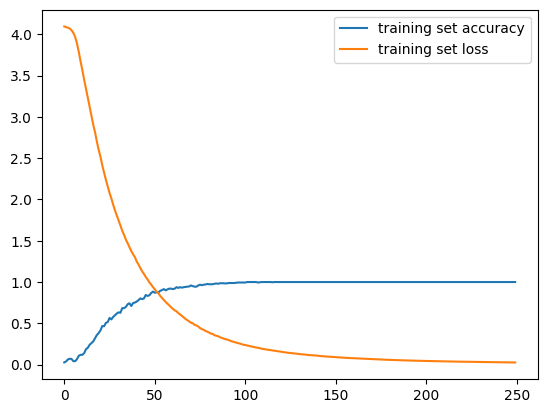

In [171]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='training set loss')
plt.legend()

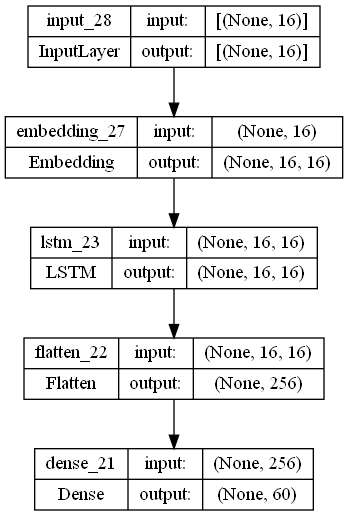

In [32]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(my_model, to_file='model-complete/model_plot.png', show_shapes=True, show_layer_names=True)

# Eksperimen 2

In [158]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1, 16)(i) # Layer Embedding
x = LSTM(16, return_sequences=True)(x) # Layer Long Short Term Memory
x = Dropout(0.25)(x)
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
my_model1 = Model(i,x)

# Compiling the model (Kompilasi Model)
my_model1.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# Menampilkan Parameter Model
my_model1.summary() 

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 16)]              0         
                                                                 
 embedding_25 (Embedding)    (None, 16, 16)            4576      
                                                                 
 lstm_21 (LSTM)              (None, 16, 16)            2112      
                                                                 
 dropout_13 (Dropout)        (None, 16, 16)            0         
                                                                 
 flatten_20 (Flatten)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 60)                15420     
                                                                 
Total params: 22,108
Trainable params: 22,108
Non-trainabl

In [159]:
# Training the model (Latih model data sampai n kali)
epoch = 250
batch_size = 32
train = my_model1.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, verbose=1)

Epoch 1/250
17/17 [==============================] - 3s 9ms/step - loss: 4.0931 - accuracy: 0.0129
Epoch 2/250
17/17 [==============================] - 0s 9ms/step - loss: 4.0823 - accuracy: 0.0423
Epoch 3/250
17/17 [==============================] - 0s 9ms/step - loss: 4.0663 - accuracy: 0.0551
Epoch 4/250
17/17 [==============================] - 0s 9ms/step - loss: 4.0343 - accuracy: 0.0643
Epoch 5/250
17/17 [==============================] - 0s 10ms/step - loss: 3.9607 - accuracy: 0.0533
Epoch 6/250
17/17 [==============================] - 0s 10ms/step - loss: 3.8429 - accuracy: 0.0680
Epoch 7/250
17/17 [==============================] - 0s 10ms/step - loss: 3.6820 - accuracy: 0.0754
Epoch 8/250
17/17 [==============================] - 0s 10ms/step - loss: 3.5736 - accuracy: 0.0901
Epoch 9/250
17/17 [==============================] - 0s 10ms/step - loss: 3.4711 - accuracy: 0.0901
Epoch 10/250
17/17 [==============================] - 0s 10ms/step - loss: 3.3503 - accuracy: 0.1176
Epo

17/17 [==============================] - 0s 12ms/step - loss: 0.0579 - accuracy: 0.9945
Epoch 163/250
17/17 [==============================] - 0s 10ms/step - loss: 0.0581 - accuracy: 0.9945
Epoch 164/250
17/17 [==============================] - 0s 10ms/step - loss: 0.0621 - accuracy: 0.9945
Epoch 165/250
17/17 [==============================] - 0s 10ms/step - loss: 0.0642 - accuracy: 0.9963
Epoch 166/250
17/17 [==============================] - 0s 11ms/step - loss: 0.0597 - accuracy: 0.9982
Epoch 167/250
17/17 [==============================] - 0s 10ms/step - loss: 0.0576 - accuracy: 0.9982
Epoch 168/250
17/17 [==============================] - 0s 10ms/step - loss: 0.0662 - accuracy: 0.9963
Epoch 169/250
17/17 [==============================] - 0s 9ms/step - loss: 0.0566 - accuracy: 0.9982
Epoch 170/250
17/17 [==============================] - 0s 10ms/step - loss: 0.0508 - accuracy: 0.9982
Epoch 171/250
17/17 [==============================] - 0s 10ms/step - loss: 0.0637 - accuracy: 0.

In [160]:
accr = my_model1.evaluate(X_train,Y_train)
print('Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17/17 [==============================] - 1s 5ms/step - loss: 0.0082 - accuracy: 1.0000
Train set
  Loss: 0.008
  Accuracy: 1.000


In [161]:
accr = my_model1.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2/2 [==============================] - 1s 8ms/step - loss: 0.4190 - accuracy: 0.9016
Test set
  Loss: 0.419
  Accuracy: 0.902


# Confusion Matrix

In [42]:
y_pred_train = my_model.predict(X_train)

10/10 [==============================] - 0s 3ms/step


In [43]:
prediction_train = []
for i in y_pred_train:
    prediction_train.append(np.argmax(i))

In [44]:
# import libraries
from sklearn.metrics import confusion_matrix
import numpy as np

# create confusion matrix
confusion_matrix = confusion_matrix(Y_train, prediction_train)
print(confusion_matrix)

[[3 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]


In [45]:
from sklearn.metrics import classification_report
print(classification_report(Y_train, prediction_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         7
          16       1.00      1.00      1.00         6
          17       1.00    

<Axes: >

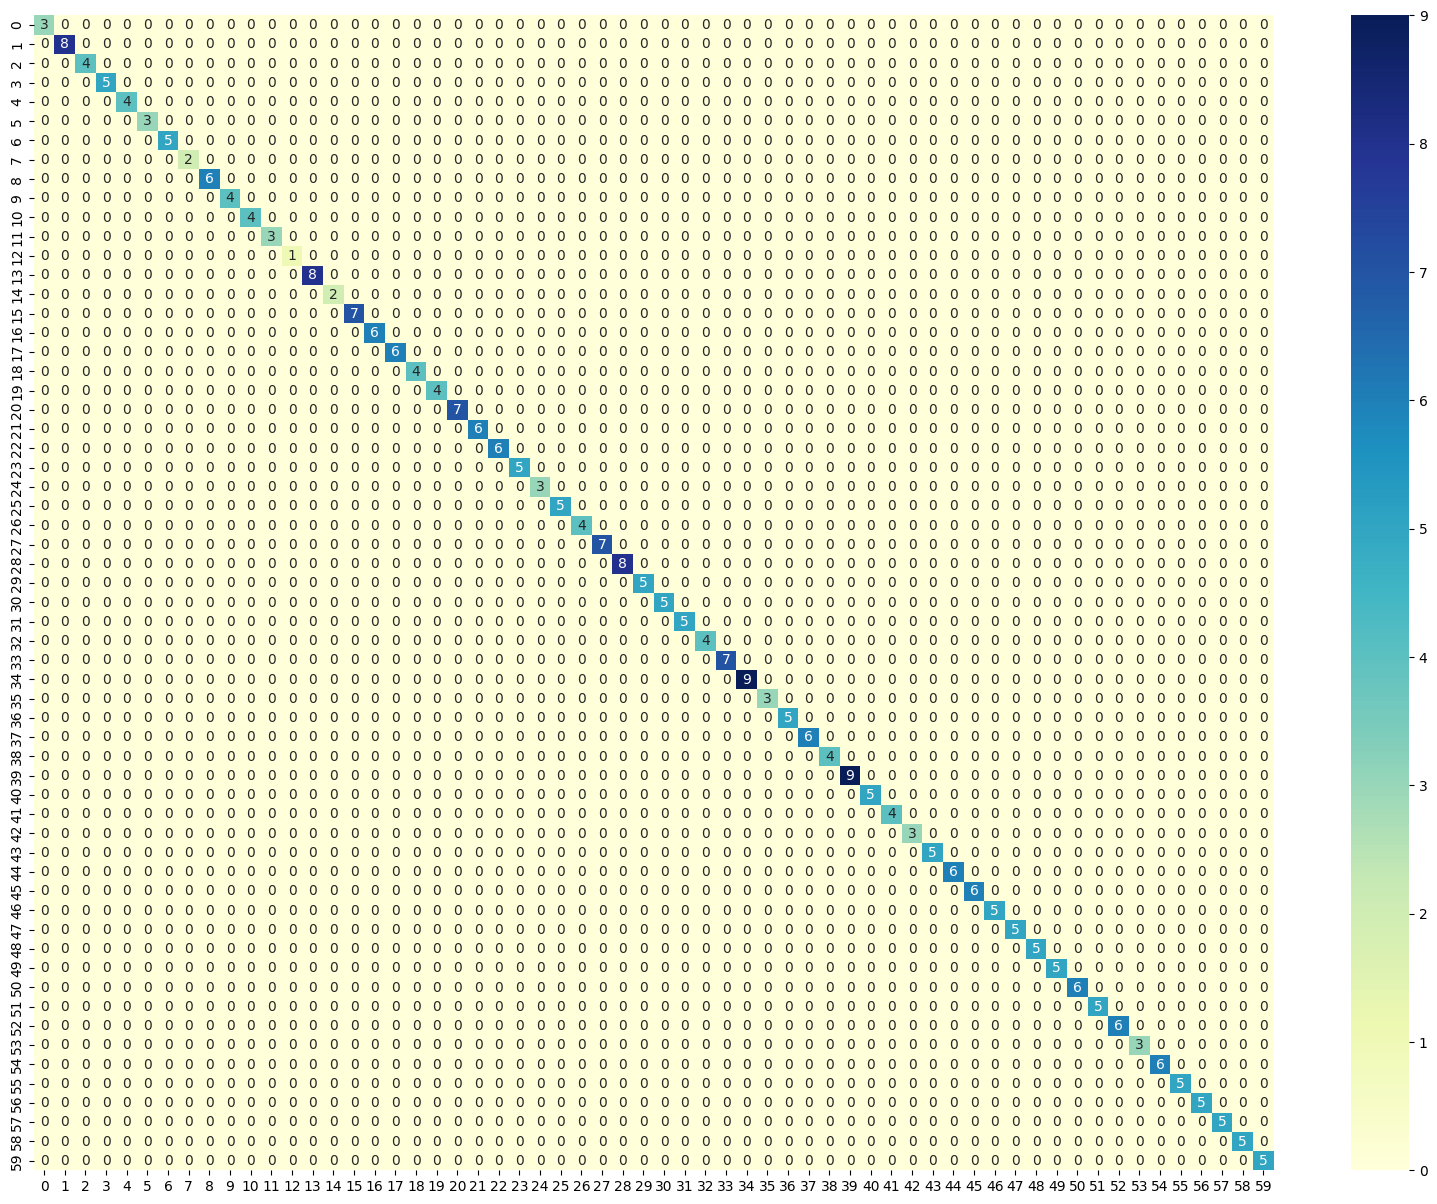

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

c_matrix = confusion_matrix(Y_train, prediction_train)
warna = sns.light_palette("blue")
plt.figure(figsize=(20,15))
sns.heatmap(c_matrix, annot = True, cmap='YlGnBu')

In [183]:
from sklearn.metrics import precision_score, recall_score, f1_score
# calculate precision
precision = precision_score(Y_train, prediction_train, pos_label='positive', average='weighted')
# calculate recall
recall = recall_score(Y_train, prediction_train, pos_label='positive', average='weighted')
# calculate f1-score
f1 = f1_score(Y_train, prediction_train, pos_label='positive', average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 1.0
Recall: 1.0
F1-score: 1.0


C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


# Confusion Matrix Testing

In [40]:
y_pred_test = my_model.predict(X_test)

9/9 [==============================] - 0s 3ms/step


In [41]:
prediction = []
for i in y_pred_test:
    prediction.append(np.argmax(i))

In [42]:
prediction[:20]

[26, 19, 28, 36, 37, 46, 19, 6, 36, 56, 40, 2, 55, 40, 6, 9, 32, 23, 57, 48]

In [43]:
# import libraries
from sklearn.metrics import confusion_matrix
import numpy as np

# create confusion matrix
confusion_matrix = confusion_matrix(Y_test, prediction)
print(confusion_matrix)

[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 3]]


In [44]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.62      1.00      0.77         5
           2       0.60      0.75      0.67         4
           3       0.67      0.50      0.57         4
           4       0.40      1.00      0.57         4
           5       0.00      0.00      0.00         6
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         3
           8       0.33      0.33      0.33         3
           9       0.44      0.80      0.57         5
          10       1.00      0.17      0.29         6
          11       1.00      0.75      0.86         4
          12       1.00      0.86      0.92         7
          13       1.00      1.00      1.00         3
          14       1.00      0.50      0.67         4
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.00         4
          17       0.75    

<Axes: >

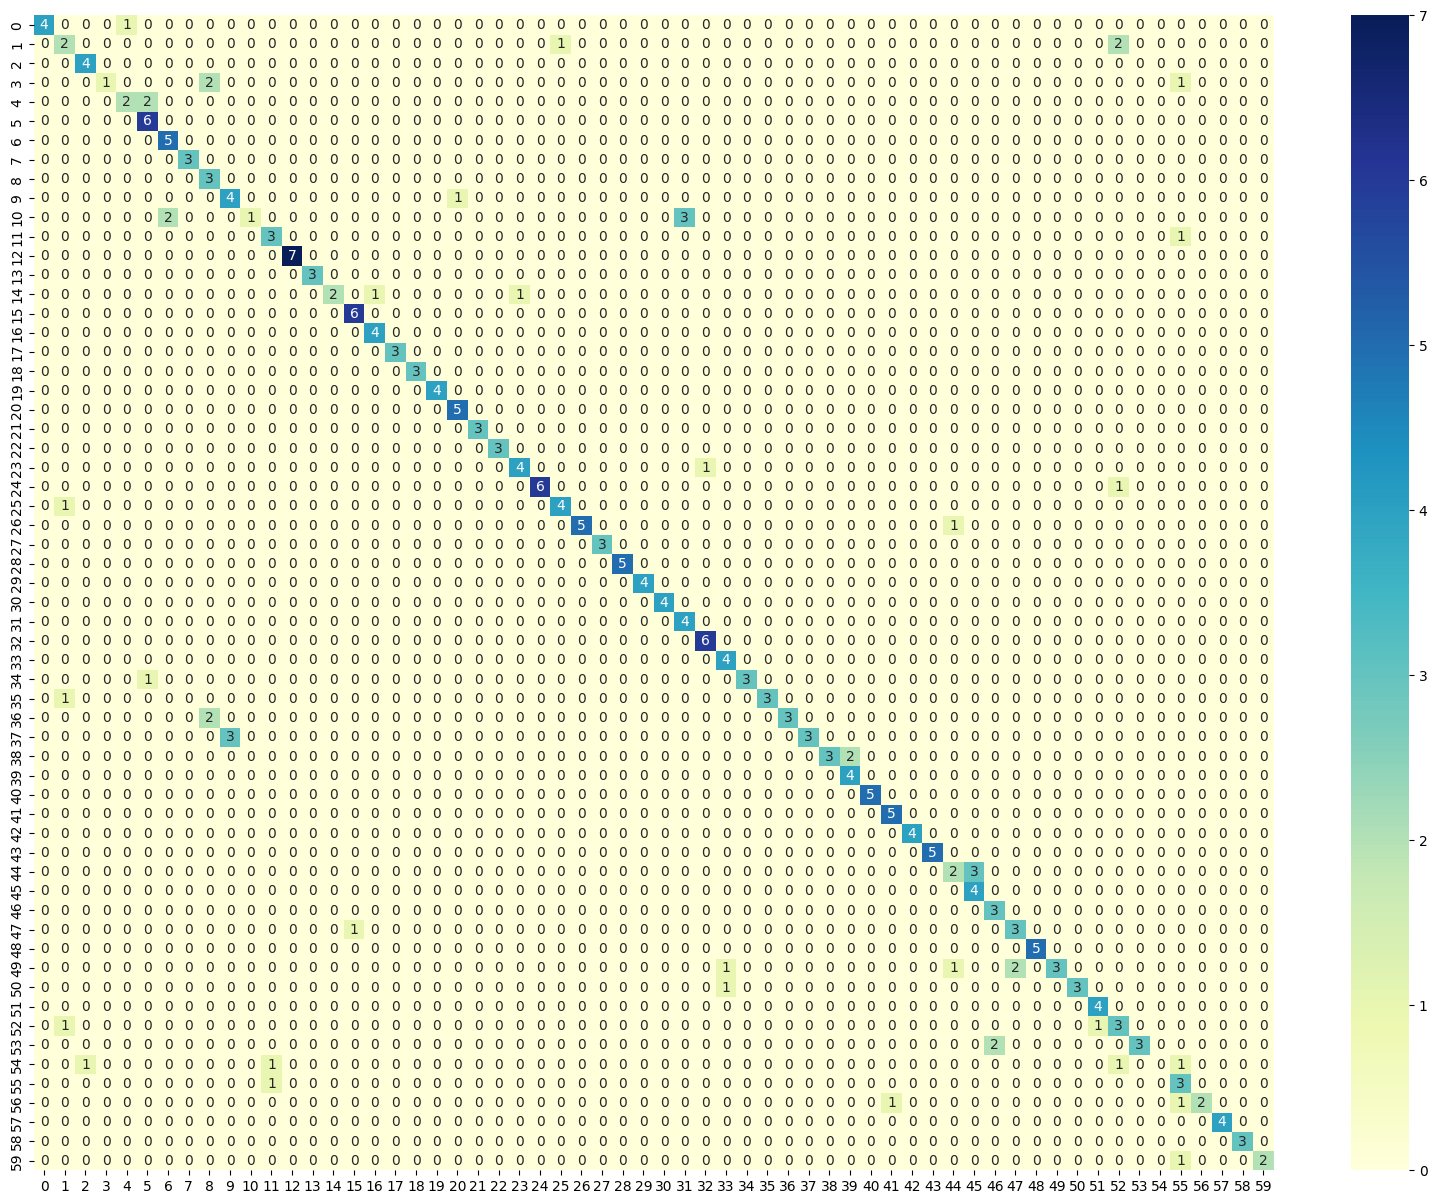

In [168]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

c_matrix = confusion_matrix(Y_test, prediction)
warna = sns.light_palette("blue")
plt.figure(figsize=(20,15))
sns.heatmap(c_matrix, annot = True, cmap='YlGnBu')

In [139]:
from collections import Counter
Counter(Y_test)

Counter({26: 6,
         19: 4,
         28: 5,
         3: 4,
         37: 6,
         46: 3,
         6: 5,
         36: 5,
         56: 4,
         40: 5,
         2: 4,
         14: 4,
         9: 5,
         49: 7,
         23: 5,
         57: 4,
         48: 5,
         30: 4,
         38: 5,
         15: 6,
         11: 4,
         12: 7,
         41: 5,
         10: 6,
         54: 4,
         35: 4,
         43: 5,
         52: 5,
         39: 4,
         31: 4,
         22: 3,
         17: 3,
         53: 5,
         59: 3,
         13: 3,
         24: 7,
         25: 5,
         8: 3,
         16: 4,
         27: 3,
         32: 6,
         33: 4,
         50: 4,
         51: 4,
         58: 3,
         1: 5,
         18: 3,
         21: 3,
         45: 4,
         20: 5,
         29: 4,
         55: 4,
         34: 4,
         0: 5,
         42: 4,
         44: 5,
         47: 4,
         5: 6,
         4: 4,
         7: 3})

In [190]:
from sklearn.metrics import precision_score, recall_score, f1_score
# calculate precision
precision = precision_score(Y_test, prediction, pos_label='positive', average='weighted')
# calculate recall
recall = recall_score(Y_test, prediction, pos_label='positive', average='weighted')
# calculate f1-score
f1 = f1_score(Y_test, prediction, pos_label='positive', average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9426229508196722
Recall: 0.9508196721311475
F1-score: 0.9398907103825136


C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\rhjha\anaconda3\envs\tf2.11\lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Not

In [ ]:
my_model.summary()

In [ ]:
weight = my_model.layers[2].get_weights()[0]
weight[1]

In [ ]:
weight.shape

In [ ]:
result=my_model.predict(X_train)

In [ ]:
print('input shape:  ', X_train.shape)
print('all_state_h shape: ', result.shape)
print('\nhidden states for the first sample: \n', result[0])
print('\nhidden states for the first sample at the second time step: \n', result[0][1])

In [ ]:
texts_p = []
prediction_input = input('Kamu : ')

# Menghapus punktuasi dan konversi ke huruf kecil
prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
prediction_input = ''.join(prediction_input)
texts_p.append(prediction_input)

# Tokenisasi dan Padding
prediction_input = tokenizer.texts_to_sequences(texts_p)
print(prediction_input)
prediction_input = np.array(prediction_input).reshape(-1)
print(prediction_input)
prediction_input = pad_sequences([prediction_input],input_shape)
print(prediction_input)

# Mendapatkan hasil keluaran pada model 
output = my_model.predict(prediction_input)
print(output[0])

output = output.argmax()
print(output)

response_tag = le.inverse_transform([output])[0]
print(response_tag)
print("ITTPBot : ", random.choice(responses[response_tag]))

In [159]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = my_model.predict(prediction_input)
  output = output.argmax()
  print(output)

#   # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("ITTPBot : ", random.choice(responses[response_tag]))
#   tts = gTTS(random.choice(responses[response_tag]), lang='id')
#   # Simpan model voice bot ke dalam Google Drive
#   tts.save('model/ITTPBot.wav')
#   time.sleep(0.08)
#   # Load model voice bot from Google Drive
#   ipd.display(ipd.Audio('model/ITTPBot.wav', autoplay=False))
#   print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

Kamu : hi
1/1 [==============================] - 0s 106ms/step
5
ITTPBot :  Helo! Ini ITTPBot. Lagi kepo tentang kampus merdeka?
Kamu : siapa kamu
1/1 [==============================] - 0s 17ms/step
0
ITTPBot :  ITTPBot adalah aplikasi chatbot informasi layanan akademik khusus program Merdeka Belajar Kampus Merdeka
Kamu : apa yang perlu dipersiapkan dalam mengikuti kampus mengajar
1/1 [==============================] - 0s 21ms/step
47
ITTPBot :  Merupakan mahasiswa aktif semester 4, memiliki IPK minimum 3.00, memiliki pengalaman mengajar maupun berorganisasi, memperoleh surat rekomendasi dari Perguruan tinggi, serta belum pernah mengikuti program Kampus Mengajar


KeyboardInterrupt: Interrupted by user

In [170]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
my_model.save('model-complete/model_2_f.h5')

print('Model Created Successfully!')

Model Created Successfully!


In [31]:
# from keras.models import load_model
# my_model = load_model('model-complete/model_u16.h5')